## Portfolio Test Data Generator

Generates synthetic multi-objective portfolio data using the DTLZ2 benchmark function.

### Components
- **Decisions** (decA, decB...): Portfolio weights that sum to 1 (Dirichlet sampling)
- **Objectives** (objA, objB...): Competing goals forming a Pareto front
- **Auxiliary** (auxA, auxB...): Additional metrics derived from decisions

### DTLZ2 Formula
The objectives are calculated as:

$$f_i(x) = (1 + g) \cdot \prod_{j=1}^{M-i} \cos\left(\frac{\pi}{2} x_j\right)^\alpha \cdot \sin\left(\frac{\pi}{2} x_{M-i}\right)^\alpha$$

Where:
- $g = \text{pareto\_spread} \cdot \sum(x_k - 0.5)^2$ — distance from the Pareto front
- $\alpha$ (curvature) — controls the front shape
- $M$ — number of objectives

### Key Parameters
| Parameter | Description |
|-----------|-------------|
| `CURVATURE` | 1=sphere, 2=linear, 0.5=convex, >3=concave |
| `PARETO_SPREAD` | 0=on front, 1=full spread |
| `OBJ_DIRECTIONS` | 'min' or 'max' per objective |


In [13]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt

class AbstractPortfolioGenerator:
    def __init__(self, n_decisions=5, n_objectives=2, n_aux=2):
        self.n_dec = n_decisions
        self.n_obj = n_objectives
        self.n_aux = n_aux

        self.dec_names = [f"dec{string.ascii_uppercase[i]}" for i in range(n_decisions)]
        self.obj_names = [f"obj{string.ascii_uppercase[i]}" for i in range(n_objectives)]
        self.aux_names = [f"aux{string.ascii_uppercase[i]}" for i in range(n_aux)]

        self.aux_weights = np.random.rand(n_aux, n_decisions)

    def _dtlz2_objectives(self, X, alpha=1.0, pareto_spread=0.0):
            """
            Calculates DTLZ2 objectives.

            alpha (curvature):
                1.0 = Spherical (Standard)
                2.0 = Linear (Flat plane)
                0.5 = Convex (bulging outward)
                >3.0 = Concave (inward curve)

            pareto_spread:
                0.0 = Exactly on the Pareto front
                1.0 = Full spread (original DTLZ2)
                0.0-1.0 = Controls tightness around front
            """
            n_samples = X.shape[0]
            objs = np.zeros((n_samples, self.n_obj))

            k = self.n_obj - 1
            X_pos = X[:, :k]
            X_g = X[:, k:]

            g_full = np.sum((X_g - 0.5)**2, axis=1)
            g = pareto_spread * g_full

            for i in range(self.n_obj):
                f = (1 + g)

                for j in range(self.n_obj - 1 - i):
                    f *= np.power(np.cos(X_pos[:, j] * np.pi / 2), alpha)

                if i > 0:
                    f *= np.power(np.sin(X_pos[:, self.n_obj - 1 - i] * np.pi / 2), alpha)

                objs[:, i] = f

            return objs

    def generate(self, n_samples=1000, curvature=1.0, dec_constraints=None, obj_constraints=None, pareto_spread=0.0, obj_directions=None):
        """
        Generate portfolio data.

        pareto_spread: 0.0 = on front, 1.0 = full spread
        obj_directions: List of 'min' or 'max' for each objective
        """
        alpha = np.ones(self.n_dec)
        dec_data = np.random.dirichlet(alpha, n_samples)

        obj_data = self._dtlz2_objectives(dec_data, curvature, pareto_spread=pareto_spread)

        if obj_directions is None:
            obj_directions = ['min'] * self.n_obj

        for i, direction in enumerate(obj_directions):
            if direction == 'max':
                obj_data[:, i] = 1 - obj_data[:, i]

        aux_data = np.dot(dec_data, self.aux_weights.T)

        df = pd.DataFrame(
            np.hstack([dec_data, obj_data, aux_data]),
            columns=self.dec_names + self.obj_names + self.aux_names
        )

        if dec_constraints:
            for constr in dec_constraints:
                df = df[df.apply(constr, axis=1)]

        if obj_constraints:
            for constr in obj_constraints:
                df = df[df.apply(constr, axis=1)]

        return df


In [14]:
# --- CONFIGURATION ---
N_SAMPLES = 50
N_DECISIONS = 6
N_OBJECTIVES = 4
N_AUX = 2
CURVATURE = 3        # 1.0=Spherical, 2.0=Linear, 0.5=Convex, >3.0=Concave
PARETO_SPREAD = 0.1  # 0.0=On front, 1.0=Full spread
OBJ_DIRECTIONS = ['max', 'max', 'max']  # 'min' or 'max' per objective

gen = AbstractPortfolioGenerator(
    n_decisions=N_DECISIONS,
    n_objectives=N_OBJECTIVES,
    n_aux=N_AUX
)

# --- CONSTRAINTS ---
decision_rules = [
    lambda r: r['decA'] < 0.40,
]

objective_rules = [
    lambda r: r['objA'] < 1.5
]

df = gen.generate(
    n_samples=N_SAMPLES,
    dec_constraints=decision_rules,
    obj_constraints=objective_rules,
    curvature=CURVATURE,
    pareto_spread=PARETO_SPREAD,
    obj_directions=OBJ_DIRECTIONS
)

print(f"Generated {len(df)} portfolios after constraints.")
df.head()


Generated 44 portfolios after constraints.


,decA,decB,decC,decD,decE,decF,objA,objB,objC,objD,auxA,auxB
0,0.091105,0.062162,0.584430,0.026392,0.023188,0.212722,0.774366,0.495209,0.999054,0.003056,0.413059,0.405428
1,0.020069,0.060906,0.229799,0.231036,0.169533,0.288658,0.175283,0.955631,0.999110,0.000032,0.517771,0.476181
3,0.021863,0.063264,0.074579,0.364463,0.062957,0.412874,0.015651,0.998396,0.999004,0.000041,0.595307,0.570350
4,0.040235,0.081267,0.125861,0.189616,0.486280,0.076741,0.060424,0.992447,0.997892,0.000259,0.497581,0.405947
5,0.388212,0.319329,0.080844,0.057297,0.084861,0.069457,0.617479,0.999204,0.935369,0.198243,0.538914,0.615997


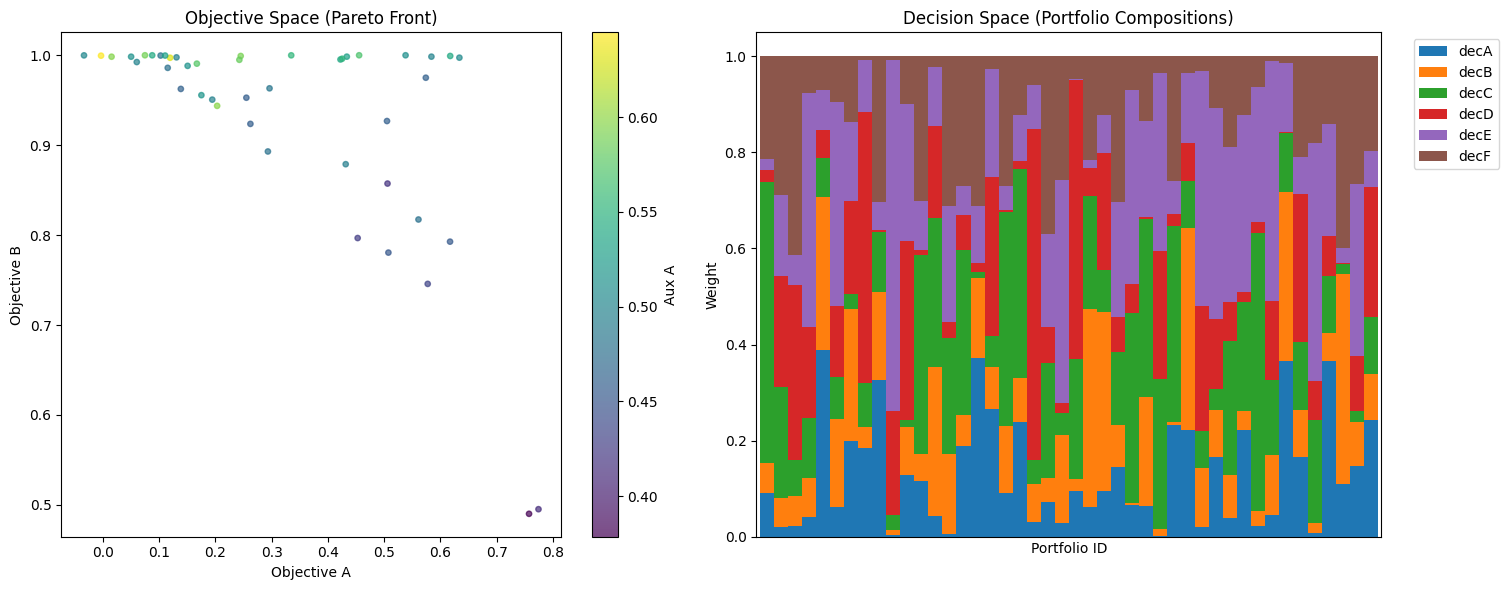

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Pareto Front
sc = axes[0].scatter(df['objA'], df['objB'], c=df['auxA'], cmap='viridis', alpha=0.7, s=15)
axes[0].set_title('Objective Space (Pareto Front)')
axes[0].set_xlabel('Objective A')
axes[0].set_ylabel('Objective B')
plt.colorbar(sc, ax=axes[0], label='Aux A')

# Portfolio Compositions
df.iloc[:50][gen.dec_names].plot(kind='bar', stacked=True, ax=axes[1], width=1.0)
axes[1].set_title('Decision Space (Portfolio Compositions)')
axes[1].set_xlabel('Portfolio ID')
axes[1].set_ylabel('Weight')
axes[1].legend(loc='upper right', bbox_to_anchor=(1.2, 1))
axes[1].set_xticks([])

plt.tight_layout()
plt.show()


In [16]:
# Export to CSV
df.to_csv('portfolio_data.csv', index=False)
print(f"Exported {len(df)} portfolios to 'portfolio_data.csv'")


Exported 44 portfolios to 'portfolio_data.csv'
